# **Input and Output Ports of the Hardware Station**


In [16]:
import numpy as np
from pydrake.all import StartMeshcat, namedview

from manipulation.exercises.grader import Grader
from manipulation.exercises.robot.test_hardware_station_io import TestHardwareStationIO
from manipulation.station import LoadScenario, MakeHardwareStation
from manipulation.utils import RenderDiagram

In [17]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://4f137116-ef3f-47c8-9bdc-a3bf697fd501.deepnoteproject.com/7001/


## Access System Input/Output Values
In this exercise, you will explore the [`HardwareStation`](http://manipulation.mit.edu/robot.html#hardware_station) that was mentioned during the lecture. You should recall that the orange ports are the ones that do not exist for the actual hardware platform.

<html>
<table align="center" cellpadding="0" cellspacing="0"><tbody><tr align="center"><td style="vertical-align:middle"><table cellspacing="0" cellpadding="0"><tbody><tr><td align="right" style="padding:5px 0px 5px 0px">iiwa.position→</td></tr><tr><td align="right" style="padding:5px 0px 5px 0px">iiwa.torque→</td></tr><tr><td align="right" style="padding:5px 0px 5px 0px">wsg.position→</td></tr><tr><td align="right" style="padding:5px 0px 5px 0px">wsg.force_limit (optional)→</td></tr></tbody></table></td><td align="center" style="border:solid;padding-left:20px;padding-right:20px;vertical-align:middle" bgcolor="#F0F0F0"><a href="https://github.com/RussTedrake/manipulation/blob/ceb817b527cbf1826c5b9a573ffbef415cb0f013/manipulation/scenarios.py#L453">HardwareStation</a></td><td style="vertical-align:middle"><table cellspacing="0" cellpadding="0"><tbody><tr><td align="left" style="padding:5px 0px 5px 0px">→ iiwa.position_commanded</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ iiwa.position_measured</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ iiwa.velocity_estimated</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ iiwa.state_estimated</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ iiwa.torque_commanded</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ iiwa.torque_measured</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ iiwa.torque_external</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ wsg.state_measured</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ wsg.force_measured</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ camera_[NAME].rgb_image</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ camera_[NAME].depth_image</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ <b style="color:orange">camera_[NAME].label_image</b></td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ ...</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ camera_[NAME].rgb_image</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ camera_[NAME].depth_image</td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ <b style="color:orange">camera_[NAME].label_image</b></td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ <b style="color:orange">query_object</b></td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ <b style="color:orange">contact_results</b></td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ <b style="color:orange">plant_continuous_state</b></td></tr><tr><td align="left" style="padding:5px 0px 5px 0px">→ <b style="color:orange">body_poses</b></td></tr></tbody></table></td></tr></tbody></table>
</html>

Now we construct a `HardwareStation` object and finalize the system setting. To get a sense of what this hardware station scenario looks like, you can open the meshcat viewer from the generated link as usual. There should be a bookshelf and a Kuka arm with a gripper attached (it might take a few seconds to load).

NOTE: The above iiwa input ports are for the default `position_and_torque` control mode. The `iiwa.torque` port does not exist in the `position_only`
control mode and the `iiwa.position` port does not exist in the `torque_only` control mode. 

In [18]:
scenario_data = """
directives:
- add_directives:
    file: package://manipulation/clutter.dmd.yaml
model_drivers:
    iiwa: !IiwaDriver
      hand_model_name: wsg
    wsg: !SchunkWsgDriver {}
"""
scenario = LoadScenario(data=scenario_data)
station = MakeHardwareStation(scenario, meshcat=meshcat)
context = station.CreateDefaultContext()

station.GetInputPort("iiwa.position").FixValue(context, np.zeros(7))
station.GetInputPort("iiwa.torque").FixValue(context, np.zeros(7))
station.GetInputPort("wsg.position").FixValue(context, [0.1])
station.ForcedPublish(context)

[**Context**](https://drake.mit.edu/pydrake/pydrake.systems.framework.html?highlight=context#pydrake.systems.framework.Context_) is an abstract class template that represents all the typed values that are used in a System’s computations: time, numeric-valued input ports, numerical state, and numerical parameters. There are also type-erased abstract state variables, abstract-valued input ports, abstract parameters, and a double accuracy setting. It is important to note that a **Context** is designed to be used only with the System that created it. State and Parameter data can be copied between contexts for compatible systems as necessary. One of the most common mistakes is to pass the wrong context. Most methods in Drake should throw an error if you pass a context from the wrong system, but a few do not perform this check yet.

In the cell below, we first create a root context from the diagram, and then we retrieve the contexts of the subsystems from the root context.

In [19]:
# initialize context
station_context = station.CreateDefaultContext()
plant = station.GetSubsystemByName("plant")
plant_context = plant.GetMyContextFromRoot(station_context)

In this exercise, you will familiarize yourself with the input and output mechanism from the hardware station system. Remember you can always generate a schematic view of your system by running the cell below. By clicking the "+" sign on the manipulation_station, you can get a more detailed view of the diverse modules within the hardware station. (You might need to run the cell twice to see the diagram)

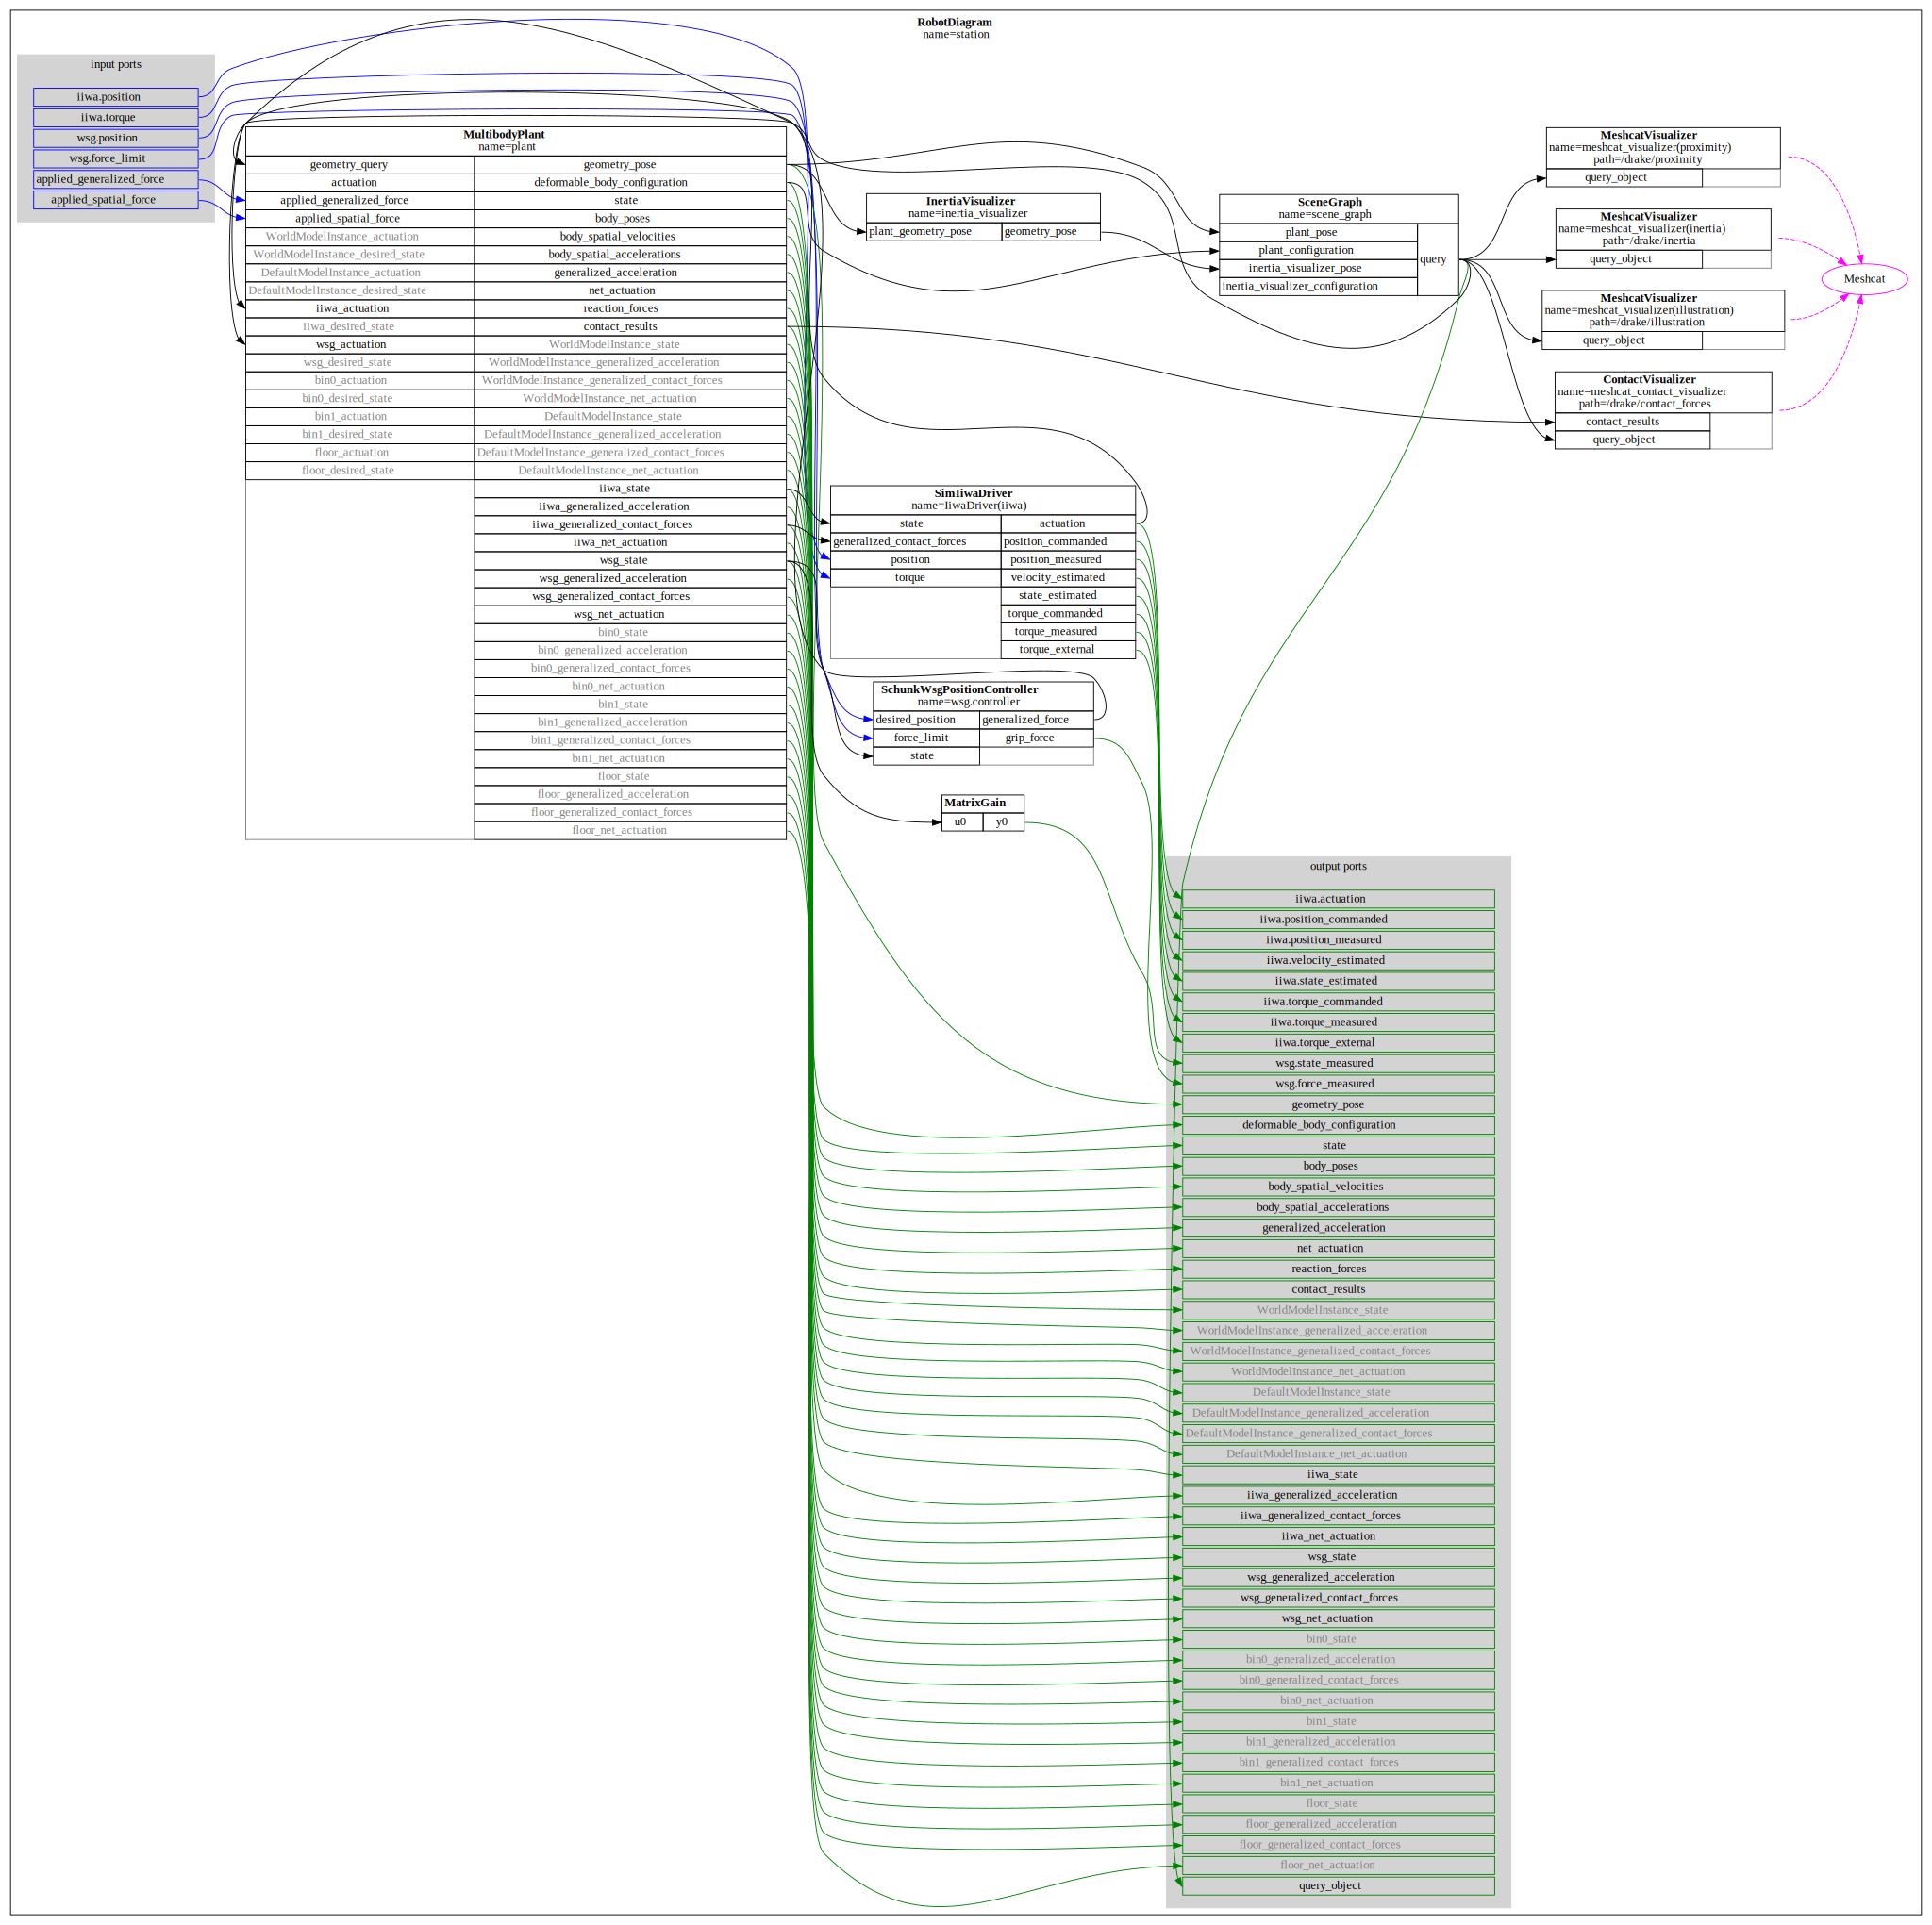

In [20]:
RenderDiagram(station, max_depth=1)

Now if we set the joint position of the Kuka arm, we should expect to get the same values from the `iiwa.position_measured port`, which can be found from the output ports of `station` object. Below we demonstrate how this can be done using Drake's syntax. You may also find it useful to review the `System` class documentation [here](https://drake.mit.edu/pydrake/pydrake.systems.framework.html?highlight=output_port#pydrake.systems.framework.System_).

In [21]:
# provide initial states
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
iiwa = plant.GetModelInstanceByName("iiwa")
# set the joint positions of the kuka arm
plant.SetPositions(plant_context, iiwa, q0)
# examine the output port
station.GetOutputPort("iiwa.position_measured").Eval(station_context)

array([-1.57,  0.1 ,  0.  , -1.2 ,  0.  ,  1.6 ,  0.  ])

Note that the [output port](https://drake.mit.edu/pydrake/pydrake.systems.framework.html?highlight=outputport#pydrake.systems.framework.OutputPort) named `iiwa.position_measured` is first retrieved from the station and then evaluated using **Eval** method. This is a very common approach to read the values of a selected output port.


*Drake advice:* use `namedview` to refer to positions by name.

In [22]:
IiwaPositionView = namedview(
    "IiwaPositions",
    plant.GetPositionNames(iiwa, always_add_suffix=False),
)
q0 = IiwaPositionView.Zero()
q0.iiwa_joint_1 = -1.57
q0.iiwa_joint_2 = 0.1
q0.iiwa_joint_4 = -1.2
q0.iiwa_joint_6 = 1.6
print(q0)
plant.SetPositions(plant_context, iiwa, q0[:])

IiwaPositions(iiwa_joint_1=-1.57, iiwa_joint_2=0.1, iiwa_joint_3=0, iiwa_joint_4=-1.2, iiwa_joint_5=0, iiwa_joint_6=1.6, iiwa_joint_7=0)


Sometimes, when working directly with a `MultibodyPlant`, you may retrieve the joint angles directly from the **plant**. But this will not work when we're running on real hardware. Use the input and output ports to properly leverage the "sim 2 real" abstraction.

In [23]:
print(plant.GetPositions(plant_context, iiwa))

[-1.57  0.1   0.   -1.2   0.    1.6   0.  ]


These examples show you how to manually set and get the positions from the command line, but please note that when you are writing a controller in Drake, you will typically not use these directly. Instead you will be constructing a `Diagram` with many `System`s whose output ports are connected to the input ports of the `HardwareStation`, and whose input ports are connected to the output ports of the `HardwareStation`.

# Exercise a: Code Submission
Now, it's your time to code! Use `GetOutputPort` and `Eval` to retrieve the joint velocities from the `iiwa.velocity_estimated` output port. Note that we have set the velocities for you.

In [24]:
plant.SetVelocities(
    plant_context,
    iiwa,
    np.zeros(
        7,
    ),
)

Below, `get_velocity(station, station_context)` is the function you must modify to query values from `iiwa.velocity_estimated`.

In [25]:
def get_velocity(station, station_context):
    """
    fill in your code in this method
    """
    velocity_estimated = station.GetOutputPort("iiwa.velocity_estimated").Eval(station_context)
    return velocity_estimated

You can check if you got the implementation correct by running the below autograder.

In [26]:
Grader.grade_output([TestHardwareStationIO], [locals()], "results.json")
Grader.print_test_results("results.json")

Total score is 5/5.

Score for Test get_velocity implementation is 5/5.


Please note that the `iiwa.position_commanded` and the `iiwa.position_measured` are NOT the same variable. The `iiwa.position_commanded` are the commanded positions sent to the robot, whereas the `iiwa.positions` are the current positions of the simulated robot. We also expect to have different values for the feed-forward torque (system input) and the commanded torque (system output). Next, you will investigate why. First, let us provide a zero feed-forward torque to the `iiwa.torque` port.

In [27]:
station.GetInputPort("iiwa.position").FixValue(station_context, np.zeros(7))
station.GetInputPort("iiwa.torque").FixValue(
    station_context,
    np.zeros(
        7,
    ),
)
tau_no_ff = station.GetOutputPort("iiwa.torque_commanded").Eval(station_context)
print(
    "feedforward torque: {}".format(
        np.zeros(
            7,
        )
    )
)
print("commanded torque with no feedforward torque:{}".format(tau_no_ff))

feedforward torque: [0. 0. 0. 0. 0. 0. 0.]
commanded torque with no feedforward torque:[ 477.02758033 -402.82897073  164.9574955   444.33536865   -2.33064192
 -403.48186403  -86.660269  ]


Now try the same experiment with a non-zero feedforward torque as shown below.

In [28]:
tau_ff = np.linspace(3.1, 3.7, 7)
print("feedforward torque: {}".format(tau_ff))
station.GetInputPort("iiwa.torque").FixValue(station_context, tau_ff)
torque_commanded = station.GetOutputPort("iiwa.torque_commanded").Eval(station_context)
print("the commanded torque: {}".format(torque_commanded))

feedforward torque: [3.1 3.2 3.3 3.4 3.5 3.6 3.7]
the commanded torque: [ 480.12758033 -399.62897073  168.2574955   447.73536865    1.16935808
 -399.88186403  -82.960269  ]


# Exercise b: Written Problem.
Below, we have a question for you.

**In this exercise, please explain what causes the discrepancy between the feedforward torque and the commanded torque.**

HINT: can you find any relationship among *tau_ff*, *tau_no_ff*, *torque_commanded*?

## Your Answer

Answer the Question here, and copy-paste to the Gradescope 'written submission' section!
torque_commanded = tau_no_ff + tau_ff


## How will this notebook be graded?

We will evaluate the local functions in the notebook to see if the function behaves as we have expected. For this exercise, the rubric is as follows:
- [5pts] `get_velocity` must be implemented correctly.
- [5pts] You must answer correctly why there is a difference between feed-forward torque and commanded torque.

## Additional Note.

So far we have not looked into the outputs of simulated camera sensors. Fortunately, accessing the camera data can be done in an almost exactly the same way as we have shown above. We will get to it soon!

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4f137116-ef3f-47c8-9bdc-a3bf697fd501' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>